In [1]:
import os
from calendar import EPOCH

import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False

In [2]:
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "data/PetImages/Cat"
    DOGS = "data/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}

    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1

                except Exception as e:
                    pass
                    # print(str(e))


            np.random.shuffle(self.training_data)
            np.save("training_data.npy", np.array(self.training_data, dtype=object))
            print("Cats::," + str(self.catcount))
            print("Dogs::," + str(self.dogcount))

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [4]:
print(len(training_data))
print(training_data[67]) #dogs
print(training_data[0]) #cats

24997
[array([[ 11,  11,  11, ...,  15,  14,  13],
        [ 13,  12,  13, ...,  14,  13,  13],
        [  9,  10,  12, ...,  15,  15,  14],
        ...,
        [ 11,  10,  12, ..., 120, 127,  61],
        [ 14,  12,  10, ..., 113, 123, 138],
        [ 24,  25,  24, ..., 174, 177, 182]], shape=(50, 50), dtype=uint8)
 array([0., 1.])]
[array([[107, 109, 111, ...,  37,  37,  34],
        [109,  99, 118, ...,  32,  31,  33],
        [ 95, 118, 135, ...,  35,  33,  31],
        ...,
        [ 81,  86,  86, ...,  27,  24,  22],
        [ 87,  89,  92, ...,  34,  53,  73],
        [ 88,  92,  98, ...,  89,  89,  86]], shape=(50, 50), dtype=uint8)
 array([1., 0.])]


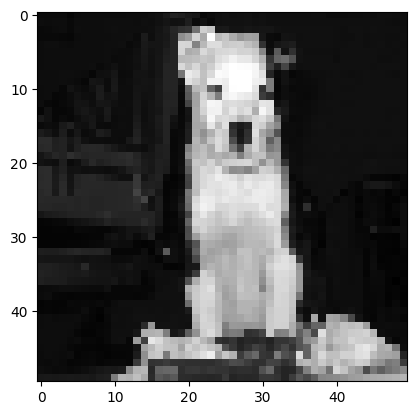

In [5]:
import matplotlib.pyplot as plt

plt.imshow(training_data[67][0], cmap="gray")
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50 * 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [8]:
net = Net()

torch.Size([128, 2, 2])


In [9]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
print(val_size)

2499


/tmp/ipykernel_102606/2993278612.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)


In [10]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22498
2499


In [11]:
#CPU Training
BATCH_SIZE = 100

EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i + BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i + BATCH_SIZE]

        net.zero_grad()
        output = net(batch_X)
        loss = loss_function(output, batch_y)
        loss.backward()
        optimizer.step()

print(loss)

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  1%|          | 2/225 [00:00<00:42,  5.29it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:00<00:37,  5.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:01<00:35,  6.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:01<00:37,  5.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:01<00:30,  7.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:02<00:27,  7.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:02<00:27,  7.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:02<00:29,  7.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:02<00:28,  7.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:02<00:27,  7.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:03<00:26,  7.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:03<00:24,  8.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:03<00:23,  8.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:04<00:22,  8.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:04<00:21,  9.10it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:04<00:21,  8.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▌        | 34/225 [00:04<00:23,  7.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:04<00:27,  6.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:05<00:33,  5.51it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:05<00:33,  5.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:05<00:30,  5.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:06<00:30,  5.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:06<00:30,  5.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:06<00:27,  6.58it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:07<00:28,  6.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:07<00:27,  6.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 54/225 [00:07<00:24,  6.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:08<00:23,  7.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:08<00:27,  6.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:08<00:27,  5.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:09<00:25,  6.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:09<00:23,  6.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:09<00:24,  6.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:09<00:22,  6.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:10<00:23,  6.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:10<00:21,  7.10it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:10<00:20,  7.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:11<00:21,  6.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:11<00:22,  6.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:11<00:23,  6.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:12<00:23,  6.10it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:12<00:21,  6.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:12<00:20,  6.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:12<00:20,  6.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:13<00:19,  7.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:13<00:22,  5.96it/s]

torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:13<00:22,  5.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:14<00:25,  5.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:14<00:23,  5.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:14<00:22,  5.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:15<00:18,  6.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:15<00:21,  5.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:16<00:19,  6.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:16<00:18,  6.29it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:16<00:16,  7.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:16<00:16,  6.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:17<00:16,  6.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:17<00:16,  6.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:17<00:15,  6.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:18<00:14,  7.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:18<00:14,  7.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:18<00:15,  6.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:19<00:20,  5.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:19<00:18,  5.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:19<00:17,  5.58it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:20<00:16,  5.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:20<00:14,  6.58it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:20<00:13,  6.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:20<00:13,  6.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:21<00:11,  7.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:21<00:10,  8.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:21<00:09,  8.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:22<00:09,  8.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:22<00:09,  8.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:22<00:09,  8.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:22<00:08,  8.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:22<00:09,  7.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:23<00:10,  7.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:23<00:09,  7.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:23<00:09,  6.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:24<00:08,  7.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:24<00:07,  8.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [00:24<00:07,  8.46it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [00:24<00:07,  7.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [00:25<00:07,  7.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [00:25<00:06,  7.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [00:25<00:06,  7.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [00:25<00:06,  8.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [00:26<00:05,  8.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [00:26<00:05,  8.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 180/225 [00:26<00:05,  8.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████  | 182/225 [00:26<00:05,  7.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [00:27<00:06,  6.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [00:27<00:05,  6.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [00:27<00:05,  6.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [00:27<00:04,  7.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [00:28<00:04,  7.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [00:28<00:04,  6.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [00:28<00:04,  6.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [00:29<00:04,  6.39it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [00:29<00:04,  5.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [00:29<00:03,  6.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [00:30<00:03,  6.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [00:30<00:02,  7.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [00:30<00:02,  6.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [00:30<00:02,  6.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [00:31<00:01,  6.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [00:31<00:01,  6.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [00:31<00:01,  6.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [00:32<00:01,  6.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [00:32<00:00,  6.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [00:32<00:00,  6.19it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [00:33<00:00,  6.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:33<00:00,  6.73it/s]

torch.Size([128, 2, 2])
tensor(0.2112, grad_fn=<MseLossBackward0>)


In [12]:
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
        predicated_class = torch.argmax(net_out)
        if predicated_class == real_class:
            correct += 1
        total += 1

print("Accuracy: ", round(correct/total, 3))

  3%|▎         | 71/2499 [00:00<00:03, 703.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 10%|█         | 251/2499 [00:00<00:02, 862.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 14%|█▎        | 342/2499 [00:00<00:02, 879.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 430/2499 [00:00<00:02, 854.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 24%|██▍       | 610/2499 [00:00<00:02, 870.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 32%|███▏      | 793/2499 [00:00<00:01, 893.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 39%|███▊      | 968/2499 [00:01<00:02, 752.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 45%|████▌     | 1131/2499 [00:01<00:01, 782.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 52%|█████▏    | 1303/2499 [00:01<00:01, 818.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 59%|█████▉    | 1469/2499 [00:01<00:01, 819.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 66%|██████▌   | 1642/2499 [00:01<00:01, 841.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 72%|███████▏  | 1811/2499 [00:02<00:00, 818.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 76%|███████▌  | 1894/2499 [00:02<00:00, 805.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 79%|███████▉  | 1975/2499 [00:02<00:00, 770.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 2053/2499 [00:02<00:00, 748.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 88%|████████▊ | 2201/2499 [00:02<00:00, 713.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 94%|█████████▍| 2358/2499 [00:02<00:00, 747.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

100%|██████████| 2499/2499 [00:03<00:00, 800.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

In [13]:
torch.cuda.is_available()

True

In [14]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [16]:
torch.cuda.device_count()

1

In [17]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [18]:
net = Net().to(device)

torch.Size([128, 2, 2])


In [19]:
EPOCHS = 10

def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    BATCH_SIZE = 100
    EPOCHS = 10
    for epoch in range(EPOCHS):
        for i in range(0, len(train_X), BATCH_SIZE):
            batch_X = train_X[i:i + BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i + BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            net.zero_grad()

            optimizer.zero_grad()
            output = net(batch_X)
            loss = loss_function(output, batch_y)
            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch}. Loss: {loss}")

In [20]:
train(net)

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

In [21]:
test_X.to(device)
test_y.to(device)

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list,
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1

    print("Accuracy: ", round(correct/total, 3))

In [22]:
test(net)

  3%|▎         | 73/2499 [00:00<00:03, 727.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

  9%|▉         | 224/2499 [00:00<00:01, 1184.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 15%|█▌        | 383/2499 [00:00<00:01, 1365.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 22%|██▏       | 542/2499 [00:00<00:01, 1450.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 28%|██▊       | 701/2499 [00:00<00:01, 1500.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 34%|███▍      | 861/2499 [00:00<00:01, 1531.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 41%|████      | 1015/2499 [00:00<00:00, 1501.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 47%|████▋     | 1166/2499 [00:00<00:00, 1413.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 52%|█████▏    | 1309/2499 [00:00<00:00, 1404.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 58%|█████▊    | 1455/2499 [00:01<00:00, 1419.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 64%|██████▍   | 1604/2499 [00:01<00:00, 1437.10it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 70%|███████   | 1757/2499 [00:01<00:00, 1464.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 77%|███████▋  | 1919/2499 [00:01<00:00, 1509.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 83%|████████▎ | 2071/2499 [00:01<00:00, 1508.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 89%|████████▉ | 2223/2499 [00:01<00:00, 1492.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

100%|██████████| 2499/2499 [00:01<00:00, 1444.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

In [23]:
correct = 0
total = 0
for i in tqdm(range(0, len(test_X), BATCH_SIZE)):

    batch_X = test_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
    batch_y = test_y[i:i+BATCH_SIZE].to(device)
    batch_out = net(batch_X)

    out_maxes = [torch.argmax(i) for i in batch_out]
    target_maxes = [torch.argmax(i) for i in batch_y]
    for i,j in zip(out_maxes, target_maxes):
        if i == j:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 25/25 [00:00<00:00, 142.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Accuracy:  0.762


In [24]:
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j)
               for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

In [37]:
def test(size=32):
    random_start = np.random.randint(len(test_X)-size)
    X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1,1,50,50).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)

torch.Size([128, 2, 2])
0.96875 tensor(0.0854, device='cuda:0')


In [38]:
import time

MODEL_NAME = f"model-{int(time.time())}"

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)
def train():
    BATCH_SIZE = 100
    EPOCHS = 10
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                if i % 50 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(), 3)}, {round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}")

train()

torch.Size([128, 2, 2])
model-1763799751


  0%|          | 0/225 [00:00<?, ?it/s]/tmp/ipykernel_102606/2563771909.py:22: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  f.write(f"{MODEL_NAME},{round(time.time(), 3)}, {round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}")
  1%|▏         | 3/225 [00:00<00:08, 26.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:00<00:06, 30.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:00<00:05, 35.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:00<00:05, 37.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:00<00:04, 38.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:01<00:05, 35.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:01<00:06, 28.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:01<00:06, 27.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:01<00:05, 31.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:02<00:04, 36.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:02<00:04, 37.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:02<00:03, 37.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:02<00:03, 35.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:02<00:03, 36.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:03<00:03, 37.25it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:03<00:02, 38.29it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:03<00:02, 38.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:03<00:02, 37.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:03<00:02, 37.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:04<00:02, 37.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:04<00:01, 38.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:04<00:01, 39.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [00:04<00:01, 39.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [00:04<00:01, 39.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [00:05<00:00, 39.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [00:05<00:00, 39.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [00:05<00:00, 38.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [00:05<00:00, 38.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [00:05<00:00, 38.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:06<00:00, 36.60it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:00<00:05, 39.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:00<00:05, 39.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:00<00:05, 38.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:00<00:05, 39.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:00<00:05, 38.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:00<00:05, 38.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:00<00:05, 39.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:00<00:04, 39.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:00<00:04, 38.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:01<00:04, 39.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:01<00:04, 37.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:01<00:04, 37.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:01<00:04, 37.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:01<00:04, 37.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:01<00:04, 38.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:01<00:04, 38.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:01<00:03, 39.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:01<00:03, 39.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:02<00:03, 39.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:02<00:03, 39.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:02<00:03, 39.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:02<00:03, 36.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:02<00:03, 37.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:02<00:03, 37.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:03<00:02, 37.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:03<00:02, 38.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:03<00:02, 38.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:03<00:02, 38.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:03<00:01, 38.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|███████   | 159/225 [00:04<00:01, 38.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:04<00:01, 37.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [00:04<00:01, 37.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [00:04<00:01, 37.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [00:04<00:01, 37.19it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [00:04<00:01, 37.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [00:04<00:01, 36.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [00:04<00:01, 36.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [00:05<00:00, 37.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [00:05<00:00, 37.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [00:05<00:00, 37.10it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [00:05<00:00, 37.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [00:05<00:00, 38.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [00:05<00:00, 37.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [00:05<00:00, 37.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [00:05<00:00, 37.21it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:05<00:00, 37.97it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:00<00:05, 38.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:00<00:05, 38.79it/s]

torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:00<00:05, 38.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:00<00:05, 38.91it/s]

torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:00<00:05, 39.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:00<00:05, 38.82it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:00<00:05, 37.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:00<00:05, 37.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:00<00:05, 37.19it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:01<00:05, 36.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:01<00:04, 36.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:01<00:04, 36.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:01<00:04, 35.40it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:01<00:04, 36.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:01<00:04, 36.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:01<00:04, 35.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:01<00:04, 35.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:01<00:04, 35.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:02<00:04, 35.07it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:02<00:04, 33.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:02<00:03, 36.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:02<00:03, 37.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:02<00:03, 38.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:02<00:03, 38.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:02<00:03, 38.53it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:03<00:02, 39.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:03<00:02, 39.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:03<00:02, 39.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:03<00:02, 39.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:03<00:02, 39.58it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:03<00:02, 39.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:03<00:02, 39.58it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:03<00:02, 39.25it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:03<00:02, 38.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:04<00:01, 39.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:04<00:01, 39.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [00:04<00:01, 39.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 180/225 [00:04<00:01, 40.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [00:04<00:01, 39.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [00:05<00:00, 39.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [00:05<00:00, 39.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [00:05<00:00, 39.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [00:05<00:00, 40.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [00:05<00:00, 38.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [00:05<00:00, 39.52it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:05<00:00, 38.25it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:00<00:05, 40.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:00<00:05, 40.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:00<00:05, 40.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:00<00:05, 39.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:00<00:05, 38.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:00<00:05, 38.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:00<00:04, 38.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:01<00:04, 37.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:01<00:04, 36.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:01<00:04, 36.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:01<00:04, 34.40it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:01<00:04, 35.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:01<00:04, 35.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:01<00:04, 35.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:01<00:04, 36.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:01<00:03, 38.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:02<00:03, 39.40it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:02<00:03, 38.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:02<00:03, 37.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:02<00:03, 37.52it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:02<00:03, 37.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:02<00:03, 37.25it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:03<00:02, 37.09it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:03<00:02, 36.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:03<00:02, 36.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:03<00:02, 38.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:03<00:02, 37.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:04<00:01, 37.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:04<00:01, 37.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [00:04<00:01, 36.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [00:04<00:01, 35.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [00:04<00:01, 35.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [00:04<00:01, 36.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [00:05<00:01, 36.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [00:05<00:00, 35.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [00:05<00:00, 36.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [00:05<00:00, 36.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [00:05<00:00, 36.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [00:05<00:00, 36.21it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [00:05<00:00, 36.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [00:05<00:00, 36.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [00:05<00:00, 36.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [00:06<00:00, 37.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:06<00:00, 37.15it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:00<00:05, 38.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:00<00:05, 39.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:00<00:05, 39.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:00<00:05, 38.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:00<00:05, 38.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:00<00:05, 38.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:00<00:05, 38.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:00<00:05, 38.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:00<00:04, 38.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:01<00:04, 38.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:01<00:04, 38.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:01<00:04, 38.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:01<00:04, 39.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:01<00:04, 38.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:01<00:04, 38.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:01<00:04, 38.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:01<00:04, 38.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:01<00:04, 37.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:01<00:03, 38.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:02<00:03, 38.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:02<00:03, 38.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:02<00:03, 38.25it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:02<00:03, 38.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:02<00:03, 38.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:02<00:03, 39.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:02<00:03, 38.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:02<00:03, 38.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:02<00:02, 38.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:03<00:02, 38.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:03<00:02, 39.09it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:03<00:02, 39.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:03<00:02, 39.10it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:03<00:02, 39.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:03<00:02, 38.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:03<00:02, 39.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:03<00:02, 38.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:03<00:01, 38.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:03<00:01, 38.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:04<00:01, 38.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:04<00:01, 37.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:04<00:01, 37.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [00:04<00:01, 38.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [00:04<00:01, 38.40it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [00:04<00:01, 38.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 181/225 [00:04<00:01, 37.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [00:04<00:01, 36.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [00:04<00:00, 37.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [00:05<00:00, 37.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [00:05<00:00, 37.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [00:05<00:00, 38.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [00:05<00:00, 38.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [00:05<00:00, 38.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [00:05<00:00, 38.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [00:05<00:00, 39.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [00:05<00:00, 39.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:05<00:00, 38.54it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:00<00:05, 39.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:00<00:05, 38.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:00<00:05, 38.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:00<00:05, 38.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:00<00:05, 38.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:00<00:05, 38.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:00<00:05, 38.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:00<00:04, 38.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:00<00:04, 38.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:01<00:04, 38.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:01<00:04, 38.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:01<00:04, 38.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:01<00:04, 38.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:01<00:04, 38.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:01<00:04, 38.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:01<00:04, 38.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:01<00:04, 38.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:01<00:03, 38.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:01<00:03, 38.53it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:02<00:03, 38.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:02<00:03, 38.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:02<00:03, 37.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:02<00:03, 38.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:02<00:03, 38.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:02<00:03, 38.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:02<00:03, 38.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:02<00:02, 38.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:02<00:02, 39.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:03<00:02, 39.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:03<00:02, 39.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:03<00:02, 39.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:03<00:02, 38.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:03<00:02, 39.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:03<00:02, 39.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:03<00:02, 39.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:03<00:02, 39.25it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:03<00:01, 39.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:03<00:01, 38.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:04<00:01, 38.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:04<00:01, 37.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [00:04<00:01, 37.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [00:04<00:01, 37.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [00:04<00:01, 37.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [00:04<00:01, 37.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████  | 182/225 [00:04<00:01, 38.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [00:04<00:01, 38.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [00:04<00:00, 37.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [00:05<00:00, 38.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [00:05<00:00, 38.40it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [00:05<00:00, 38.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [00:05<00:00, 38.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [00:05<00:00, 38.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [00:05<00:00, 39.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [00:05<00:00, 39.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [00:05<00:00, 38.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:05<00:00, 38.57it/s]


torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:00<00:05, 39.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:00<00:05, 38.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:00<00:05, 38.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:00<00:05, 38.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:00<00:05, 38.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:00<00:05, 38.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:00<00:05, 38.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:00<00:05, 38.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:00<00:05, 36.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:01<00:04, 37.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:01<00:04, 38.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:01<00:04, 38.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:01<00:04, 38.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:01<00:04, 38.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:01<00:04, 39.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:01<00:04, 38.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:01<00:04, 38.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:01<00:04, 37.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:02<00:03, 37.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:02<00:03, 37.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:02<00:03, 37.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:02<00:03, 37.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:02<00:03, 37.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:02<00:03, 37.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:02<00:03, 37.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:02<00:03, 38.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:02<00:03, 38.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:02<00:02, 39.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:03<00:02, 38.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:03<00:02, 37.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:03<00:02, 36.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:03<00:02, 36.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:03<00:02, 34.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:03<00:02, 34.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:03<00:02, 35.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:03<00:02, 36.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:03<00:02, 37.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:04<00:01, 37.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:04<00:01, 38.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:04<00:01, 38.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [00:04<00:01, 38.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [00:04<00:01, 38.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [00:04<00:01, 38.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [00:04<00:01, 38.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████  | 182/225 [00:04<00:01, 38.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [00:04<00:00, 39.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [00:05<00:00, 39.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [00:05<00:00, 38.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [00:05<00:00, 38.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [00:05<00:00, 38.29it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [00:05<00:00, 38.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [00:05<00:00, 38.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [00:05<00:00, 38.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [00:05<00:00, 38.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [00:05<00:00, 38.46it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:05<00:00, 37.93it/s]


torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:00<00:05, 38.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:00<00:05, 36.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:00<00:05, 36.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:00<00:05, 36.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:00<00:05, 37.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:00<00:05, 37.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:00<00:05, 38.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:00<00:05, 38.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:00<00:04, 38.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:01<00:04, 37.53it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:01<00:04, 37.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:01<00:04, 37.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:01<00:04, 37.09it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:01<00:04, 35.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:01<00:04, 33.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:01<00:04, 33.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:01<00:04, 34.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:01<00:04, 35.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:02<00:04, 36.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:02<00:03, 36.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:02<00:03, 36.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:02<00:03, 36.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:02<00:03, 36.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:02<00:03, 36.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:02<00:03, 36.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:02<00:03, 37.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:02<00:03, 36.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:03<00:03, 36.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:03<00:02, 36.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:03<00:02, 36.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:03<00:02, 37.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:03<00:02, 35.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:03<00:02, 36.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:03<00:02, 36.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 140/225 [00:03<00:02, 36.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:03<00:02, 37.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:04<00:02, 37.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:04<00:01, 37.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:04<00:01, 37.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|███████   | 160/225 [00:04<00:01, 37.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [00:04<00:01, 37.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [00:04<00:01, 36.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [00:04<00:01, 36.09it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [00:04<00:01, 36.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 180/225 [00:04<00:01, 36.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [00:05<00:01, 37.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [00:05<00:00, 37.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [00:05<00:00, 38.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [00:05<00:00, 38.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [00:05<00:00, 39.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [00:05<00:00, 39.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [00:05<00:00, 39.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [00:05<00:00, 39.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [00:05<00:00, 40.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:06<00:00, 37.28it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:00<00:05, 38.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:00<00:05, 39.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:00<00:05, 39.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:00<00:05, 39.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:00<00:05, 39.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:00<00:04, 39.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:00<00:04, 39.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:00<00:04, 39.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:00<00:04, 39.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:01<00:04, 39.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:01<00:04, 39.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:01<00:04, 39.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:01<00:04, 39.52it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:01<00:04, 39.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:01<00:04, 39.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:01<00:03, 39.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:01<00:03, 39.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:01<00:03, 39.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:02<00:03, 39.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:02<00:03, 39.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 90/225 [00:02<00:03, 39.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:02<00:03, 39.58it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:02<00:03, 39.63it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:02<00:03, 39.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:02<00:02, 39.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:02<00:02, 38.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:02<00:02, 39.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:03<00:02, 39.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:03<00:02, 39.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:03<00:02, 39.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:03<00:02, 38.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:03<00:02, 38.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:03<00:02, 39.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:03<00:02, 39.21it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:03<00:01, 39.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:03<00:01, 39.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:03<00:01, 39.09it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:04<00:01, 38.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:04<00:01, 38.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [00:04<00:01, 38.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [00:04<00:01, 38.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [00:04<00:01, 38.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 181/225 [00:04<00:01, 38.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [00:04<00:01, 38.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [00:04<00:00, 38.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [00:04<00:00, 38.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [00:05<00:00, 38.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [00:05<00:00, 37.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [00:05<00:00, 38.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [00:05<00:00, 38.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [00:05<00:00, 38.79it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [00:05<00:00, 38.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [00:05<00:00, 38.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:05<00:00, 39.09it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:00<00:05, 38.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:00<00:05, 38.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:00<00:05, 38.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:00<00:05, 38.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:00<00:05, 38.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:00<00:05, 38.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:00<00:05, 39.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:00<00:04, 39.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:00<00:04, 38.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:01<00:05, 35.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:01<00:05, 35.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:01<00:04, 36.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:01<00:04, 37.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:01<00:04, 38.10it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:01<00:04, 36.46it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:01<00:04, 36.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:01<00:04, 36.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:01<00:04, 36.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:02<00:03, 37.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:02<00:03, 37.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:02<00:03, 37.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:02<00:03, 36.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:02<00:03, 37.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:02<00:03, 37.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:02<00:03, 38.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:02<00:03, 38.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:02<00:03, 38.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:02<00:02, 38.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:03<00:02, 38.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:03<00:02, 38.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:03<00:02, 38.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:03<00:02, 38.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:03<00:02, 38.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:03<00:02, 38.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:03<00:02, 36.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:03<00:02, 36.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:03<00:02, 37.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:04<00:01, 37.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:04<00:01, 38.30it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:04<00:01, 38.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:04<00:01, 38.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [00:04<00:01, 38.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [00:04<00:01, 39.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [00:04<00:01, 39.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [00:04<00:01, 39.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [00:04<00:00, 39.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [00:05<00:00, 40.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [00:05<00:00, 40.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [00:05<00:00, 40.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [00:05<00:00, 39.53it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [00:05<00:00, 39.53it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 216/225 [00:05<00:00, 39.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [00:05<00:00, 39.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:05<00:00, 38.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
